# Data Loading and Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import Adam

# Load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
data = pd.read_csv(url, parse_dates=['Date'], index_col='Date')

print("Dataset shape:", data.shape)
print("\nFirst few rows:")
print(data.head())
print("\nDataset info:")
print(data.info())

Dataset shape: (3650, 1)

First few rows:
            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8

Dataset info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Temp    3650 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB
None


# Data Visualization

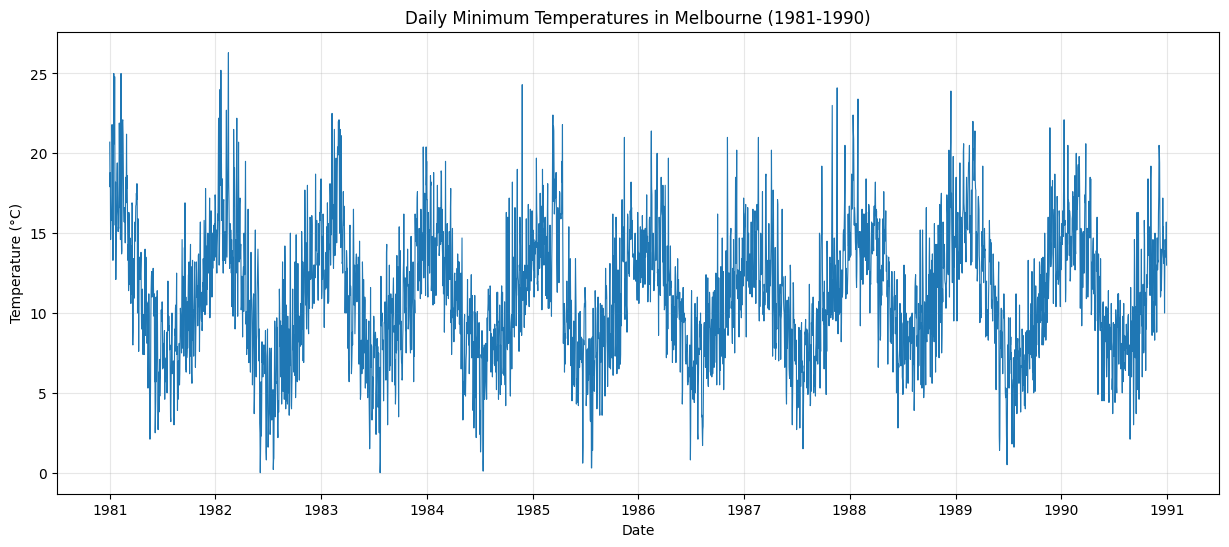

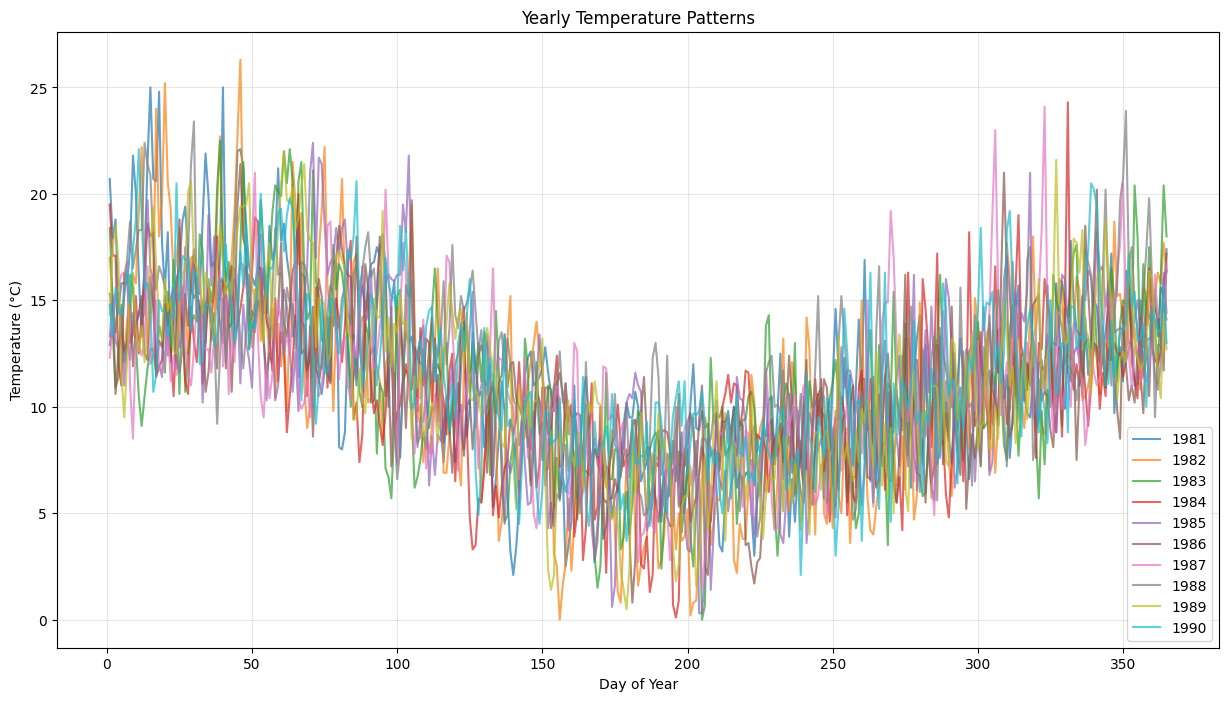

Statistical Summary:
              Temp
count  3650.000000
mean     11.177753
std       4.071837
min       0.000000
25%       8.300000
50%      11.000000
75%      14.000000
max      26.300000


In [2]:
# Plot the entire time series
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['Temp'], linewidth=0.8)
plt.title('Daily Minimum Temperatures in Melbourne (1981-1990)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True, alpha=0.3)
plt.show()

# Plot yearly patterns
plt.figure(figsize=(15, 8))
for year in range(1981, 1991):
    year_data = data[data.index.year == year]
    plt.plot(year_data.index.dayofyear, year_data['Temp'], label=str(year), alpha=0.7)
plt.title('Yearly Temperature Patterns')
plt.xlabel('Day of Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Statistical summary
print("Statistical Summary:")
print(data.describe())

# Data Preprocessing for Time Series

In [4]:
class TemperaturePredictor:
    def __init__(self, lookback=30):
        self.lookback = lookback
        self.scaler = MinMaxScaler()
        
    def prepare_data(self, data):
        """Prepare data for both feedforward and RNN models"""
        # Normalize the data
        scaled_data = self.scaler.fit_transform(data.values.reshape(-1, 1))
        
        # Create sequences for time series prediction
        X, y = [], []
        for i in range(self.lookback, len(scaled_data)):
            X.append(scaled_data[i-self.lookback:i, 0])
            y.append(scaled_data[i, 0])
        
        X, y = np.array(X), np.array(y)
        
        # Split into train/test (80/20)
        split_idx = int(0.8 * len(X))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        # Reshape for RNN (samples, timesteps, features)
        X_train_rnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_test_rnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        
        return (X_train, X_test, y_train, y_test, 
                X_train_rnn, X_test_rnn, y_train, y_test)

# Feedforward Neural Network Model

In [5]:
def build_feedforward_model(lookback):
    """Build a simple feedforward neural network"""
    model = Sequential([
        Dense(64, activation='relu', input_shape=(lookback,)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mse',
                 metrics=['mae'])
    
    return model

def train_feedforward_model(X_train, X_test, y_train, y_test, lookback):
    """Train and evaluate feedforward model"""
    model = build_feedforward_model(lookback)
    
    history = model.fit(X_train, y_train,
                       batch_size=32,
                       epochs=50,
                       validation_data=(X_test, y_test),
                       verbose=1)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    return model, history, y_pred

# RNN Model

In [6]:
def build_rnn_model(lookback):
    """Build a Simple RNN model"""
    model = Sequential([
        SimpleRNN(50, activation='tanh', return_sequences=True, 
                 input_shape=(lookback, 1)),
        SimpleRNN(30, activation='tanh'),
        Dense(20, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mse',
                 metrics=['mae'])
    
    return model

def train_rnn_model(X_train_rnn, X_test_rnn, y_train, y_test):
    """Train and evaluate RNN model"""
    model = build_rnn_model(X_train_rnn.shape[1])
    
    history = model.fit(X_train_rnn, y_train,
                       batch_size=32,
                       epochs=50,
                       validation_data=(X_test_rnn, y_test),
                       verbose=1)
    
    # Make predictions
    y_pred = model.predict(X_test_rnn)
    
    return model, history, y_pred

# Complete Training and Comparison

In [7]:
def main():
    # Initialize predictor
    lookback = 30  # Use 30 days to predict next day
    predictor = TemperaturePredictor(lookback=lookback)
    
    # Prepare data
    (X_train, X_test, y_train, y_test,
     X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn) = predictor.prepare_data(data['Temp'])
    
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Test samples: {X_test.shape[0]}")
    print(f"Lookback period: {lookback} days")
    
    # Train Feedforward Network
    print("\n" + "="*50)
    print("TRAINING FEEDFORWARD NETWORK")
    print("="*50)
    ff_model, ff_history, ff_pred = train_feedforward_model(X_train, X_test, y_train, y_test, lookback)
    
    # Train RNN
    print("\n" + "="*50)
    print("TRAINING RNN")
    print("="*50)
    rnn_model, rnn_history, rnn_pred = train_rnn_model(X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn)
    
    # Inverse transform predictions to original scale
    ff_pred_actual = predictor.scaler.inverse_transform(ff_pred.reshape(-1, 1))
    rnn_pred_actual = predictor.scaler.inverse_transform(rnn_pred.reshape(-1, 1))
    y_test_actual = predictor.scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate metrics
    ff_rmse = np.sqrt(mean_squared_error(y_test_actual, ff_pred_actual))
    ff_mae = mean_absolute_error(y_test_actual, ff_pred_actual)
    
    rnn_rmse = np.sqrt(mean_squared_error(y_test_actual, rnn_pred_actual))
    rnn_mae = mean_absolute_error(y_test_actual, rnn_pred_actual)
    
    print("\n" + "="*60)
    print("MODEL COMPARISON RESULTS")
    print("="*60)
    print(f"Feedforward Network - RMSE: {ff_rmse:.3f}, MAE: {ff_mae:.3f}")
    print(f"RNN - RMSE: {rnn_rmse:.3f}, MAE: {rnn_mae:.3f}")
    
    return (ff_model, rnn_model, ff_history, rnn_history, 
            ff_pred_actual, rnn_pred_actual, y_test_actual, predictor)

# Run the complete pipeline
results = main()
ff_model, rnn_model, ff_history, rnn_history, ff_pred, rnn_pred, y_test_actual, predictor = results

Training samples: 2896
Test samples: 724
Lookback period: 30 days

TRAINING FEEDFORWARD NETWORK


C:\Users\bbuser\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0510 - mae: 0.1445 - val_loss: 0.0108 - val_mae: 0.0807
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0117 - mae: 0.0850 - val_loss: 0.0089 - val_mae: 0.0735
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0106 - mae: 0.0811 - val_loss: 0.0086 - val_mae: 0.0721
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0101 - mae: 0.0790 - val_loss: 0.0082 - val_mae: 0.0708
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0098 - mae: 0.0778 - val_loss: 0.0077 - val_mae: 0.0687
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0096 - mae: 0.0772 - val_loss: 0.0078 - val_mae: 0.0692
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0096 - mae: 0.0772 - val_loss: 0.0090 - val_mae: 0.0752
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - mae: 0.0760 - val_loss: 0.0074 - val_mae: 0.0672
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - mae:

C:\Users\bbuser\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 0.0176 - mae: 0.1019 - val_loss: 0.0089 - val_mae: 0.0744
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0108 - mae: 0.0817 - val_loss: 0.0086 - val_mae: 0.0737
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0099 - mae: 0.0781 - val_loss: 0.0090 - val_mae: 0.0767
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0093 - mae: 0.0755 - val_loss: 0.0086 - val_mae: 0.0731
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0092 - mae: 0.0754 - val_loss: 0.0073 - val_mae: 0.0678
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0095 - mae: 0.0760 - val_loss: 0.0072 - val_mae: 0.0672
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0092 - mae: 0.0756 - val_loss: 0.0073 - val_mae: 0.0679
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0101 - mae: 0.0788 - val_loss: 0.0075 - val_mae: 0.0679
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.00

# Visualization and Analysis

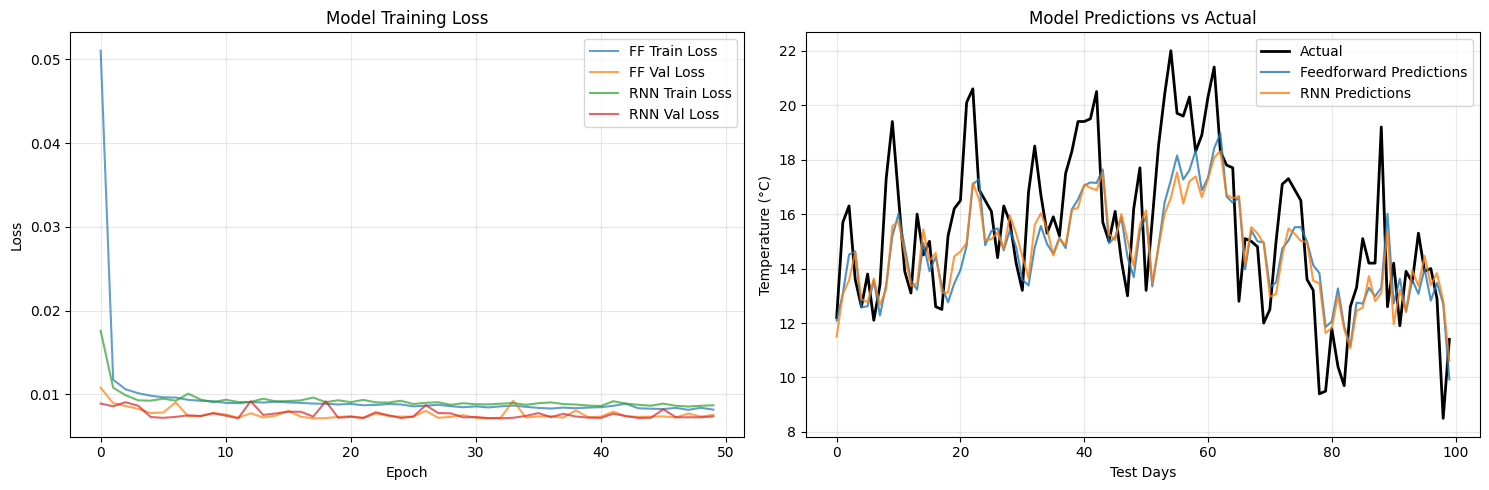

In [8]:
def plot_comparison(ff_history, rnn_history, ff_pred, rnn_pred, y_test_actual):
    """Plot training history and predictions comparison"""
    
    # Plot training history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss comparison
    ax1.plot(ff_history.history['loss'], label='FF Train Loss', alpha=0.7)
    ax1.plot(ff_history.history['val_loss'], label='FF Val Loss', alpha=0.7)
    ax1.plot(rnn_history.history['loss'], label='RNN Train Loss', alpha=0.7)
    ax1.plot(rnn_history.history['val_loss'], label='RNN Val Loss', alpha=0.7)
    ax1.set_title('Model Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Predictions comparison
    test_days = range(100)  # Show first 100 test days
    ax2.plot(test_days, y_test_actual[test_days].flatten(), 
             label='Actual', color='black', linewidth=2)
    ax2.plot(test_days, ff_pred[test_days].flatten(), 
             label='Feedforward Predictions', alpha=0.8)
    ax2.plot(test_days, rnn_pred[test_days].flatten(), 
             label='RNN Predictions', alpha=0.8)
    ax2.set_title('Model Predictions vs Actual')
    ax2.set_xlabel('Test Days')
    ax2.set_ylabel('Temperature (°C)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Generate comparison plots
plot_comparison(ff_history, rnn_history, ff_pred, rnn_pred, y_test_actual)

# Advanced Analysis: Understanding Temporal Patterns

In [17]:
def analyze_rnn_architecture(rnn_model):
    """Analyze RNN architecture and parameters"""
    print("\n" + "="*50)
    print("RNN ARCHITECTURE ANALYSIS")
    print("="*50)
    
    # Show model architecture
    rnn_model.summary()
    
    print(f"\nRNN Layer Information:")
    rnn_layers = []
    for i, layer in enumerate(rnn_model.layers):
        layer_info = {
            'index': i,
            'name': layer.name,
            'type': layer.__class__.__name__
        }
        
        if 'rnn' in layer.name.lower():
            layer_info['units'] = getattr(layer, 'units', 'N/A')
            layer_info['activation'] = getattr(layer.activation, '__name__', 'N/A')
            layer_info['return_sequences'] = getattr(layer, 'return_sequences', 'N/A')
            rnn_layers.append(layer_info)
            
            print(f"Layer {i}: {layer.name}")
            print(f"  Type: {layer.__class__.__name__}")
            print(f"  Units: {getattr(layer, 'units', 'N/A')}")
            print(f"  Activation: {getattr(layer.activation, '__name__', 'N/A')}")
            print(f"  Return sequences: {getattr(layer, 'return_sequences', 'N/A')}")
    
    # Calculate total parameters
    total_params = rnn_model.count_params()
    print(f"\nTotal parameters in RNN model: {total_params:,}")
    
    return rnn_layers

# Run RNN architecture analysis
print("\nAnalyzing RNN architecture...")
rnn_layers_info = analyze_rnn_architecture(results[1])  # results[1] is rnn_model


Analyzing RNN architecture...

RNN ARCHITECTURE ANALYSIS


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 30, 50)              │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 30)                  │           2,430 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 20)                  │             620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,015 (66.47 KB)

 Trainable params: 5,671 (22.15 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,344 (44.32 KB)


RNN Layer Information:
Layer 0: simple_rnn
  Type: SimpleRNN
  Units: 50
  Activation: tanh
  Return sequences: True
Layer 1: simple_rnn_1
  Type: SimpleRNN
  Units: 30
  Activation: tanh
  Return sequences: False

Total parameters in RNN model: 5,671


Step 1: Running temporal pattern analysis...
Analyzing RNN temporal patterns...


C:\Users\bbuser\AppData\Local\Temp\ipykernel_12444\113766559.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_rmse_rnn = results_df.groupby('month').apply(
C:\Users\bbuser\AppData\Local\Temp\ipykernel_12444\113766559.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_rmse_ff = results_df.groupby('month').apply(


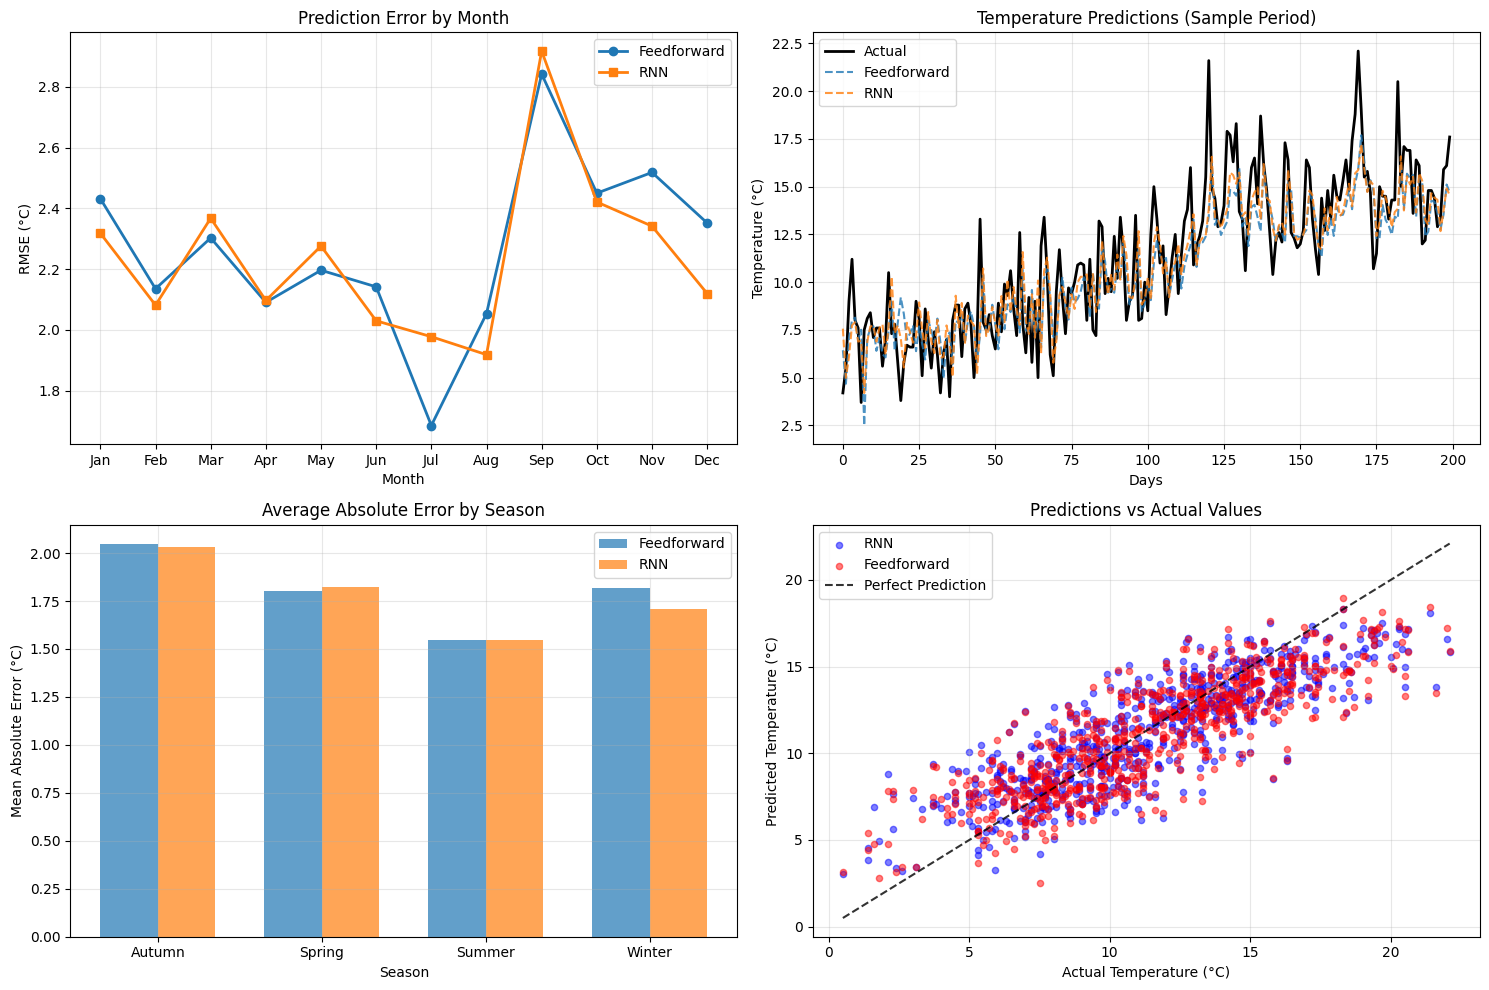


DETAILED TEMPORAL PATTERN ANALYSIS

Overall Performance:
RNN Overall RMSE: 2.253°C
Feedforward Overall RMSE: 2.282°C

Best Performing Month for RNN: Aug (RMSE: 1.918°C)
Worst Performing Month for RNN: Sep (RMSE: 2.918°C)

Seasonal Performance (RNN):
  Winter: RMSE = 2.174°C
  Spring: RMSE = 2.251°C
  Summer: RMSE = 1.975°C
  Autumn: RMSE = 2.571°C

Trend Analysis:
RNN correlation with temperature changes: -0.101
Feedforward correlation with temperature changes: -0.125
→ RNN better captures daily temperature changes
✓ Temporal pattern analysis completed!

Step 2: Running comprehensive performance analysis...

COMPREHENSIVE PERFORMANCE ANALYSIS

📊 PERFORMANCE METRICS:
Metric          Feedforward  RNN          Improvement    
-------------------------------------------------------
RMSE            2.282°C     2.253°C     +1.3%
MAE             1.802°C     1.777°C     +1.4%
R²              0.690        0.698        +1.1%
Final Loss      0.0075     0.0073     +2.5%
Parameters      4609      

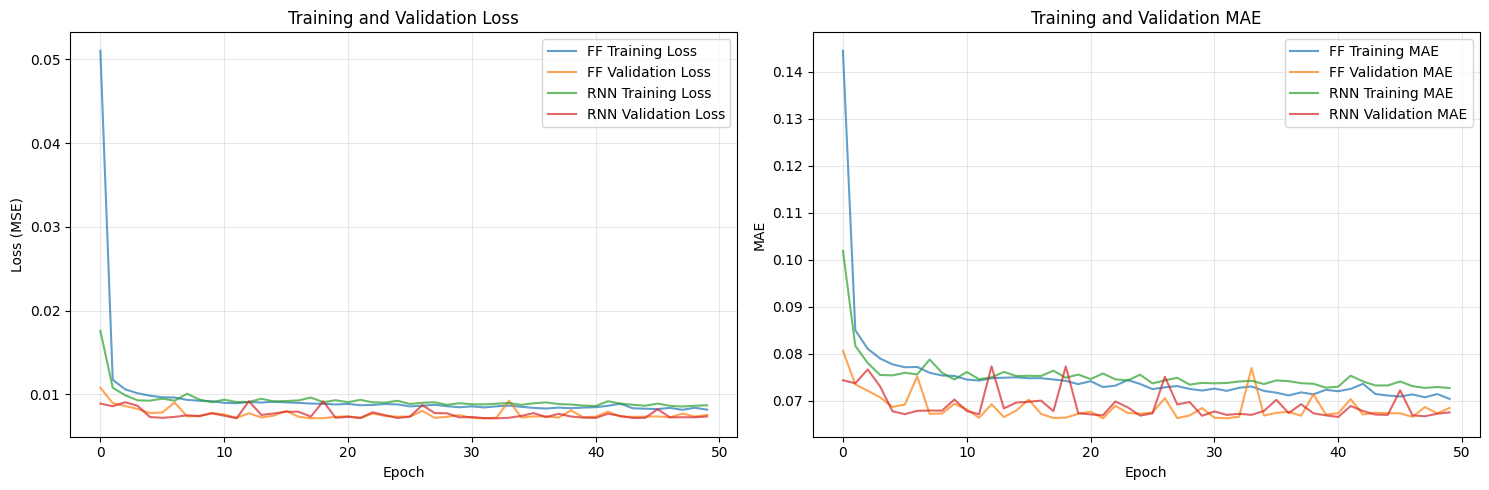


🔄 TRAINING CONVERGENCE ANALYSIS:
Feedforward - Final Val Loss: 0.0075, Final Val MAE: 0.0685
RNN         - Final Val Loss: 0.0073, Final Val MAE: 0.0676
→ RNN achieved better convergence than Feedforward network
✓ Training comparison completed!

Step 5: Generating project summary...

PROJECT SUMMARY: RNNs vs FEEDFORWARD NETWORKS FOR TIME SERIES

🎯 PROJECT GOALS ACHIEVED:
✓ Learned to preprocess real time series data for RNNs
✓ Compared Feedforward NN vs RNN on the same prediction task
✓ Observed how RNNs learn temporal patterns and trends
✓ Understood practical differences in model architecture and performance

📊 DATASET USED:
• Daily Minimum Temperatures in Melbourne, Australia
• 10 years of data (1981-1990)
• 3650 daily observations
• Task: Predict next day's minimum temperature

🔧 TECHNICAL IMPLEMENTATION:
• Data preprocessing: Normalization and sequence creation
• Lookback period: 30 days to predict next day
• Feedforward: 3 dense layers (64-32-16-1 neurons)
• RNN: 2 SimpleRNN lay

In [20]:
# First, let's run the temporal pattern analysis to create temporal_results
print("Step 1: Running temporal pattern analysis...")

def analyze_temporal_patterns(results):
    """Analyze how the RNN captures temporal patterns"""
    # Unpack the results tuple properly
    ff_model, rnn_model, ff_history, rnn_history, ff_pred, rnn_pred, y_test_actual, predictor = results
    
    print("Analyzing RNN temporal patterns...")
    
    # We need to recreate the data_dict since it wasn't returned in main()
    lookback = 30
    predictor_temp = TemperaturePredictor(lookback=lookback)
    data_dict = predictor_temp.prepare_data(data['Temp'])
    
    # 1. Create a DataFrame for temporal analysis
    test_dates = data.index[-len(rnn_pred):]
    results_df = pd.DataFrame({
        'date': test_dates,
        'actual': y_test_actual.flatten(),
        'predicted_rnn': rnn_pred.flatten(),
        'predicted_ff': ff_pred.flatten()
    })
    
    # 2. Analyze performance by month
    results_df['month'] = results_df['date'].dt.month
    results_df['season'] = results_df['month'].apply(lambda x: 
        'Winter' if x in [12, 1, 2] else
        'Spring' if x in [3, 4, 5] else
        'Summer' if x in [6, 7, 8] else 'Autumn')
    
    monthly_rmse_rnn = results_df.groupby('month').apply(
        lambda x: np.sqrt(mean_squared_error(x['actual'], x['predicted_rnn']))
    )
    
    monthly_rmse_ff = results_df.groupby('month').apply(
        lambda x: np.sqrt(mean_squared_error(x['actual'], x['predicted_ff']))
    )
    
    # 3. Plot monthly performance comparison
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Monthly RMSE comparison
    plt.subplot(2, 2, 1)
    months = range(1, 13)
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    plt.plot(months, monthly_rmse_ff.values, 'o-', label='Feedforward', linewidth=2, markersize=6)
    plt.plot(months, monthly_rmse_rnn.values, 's-', label='RNN', linewidth=2, markersize=6)
    plt.title('Prediction Error by Month')
    plt.xlabel('Month')
    plt.ylabel('RMSE (°C)')
    plt.xticks(months, month_names)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Seasonal patterns - actual vs predicted
    plt.subplot(2, 2, 2)
    # Show 200 days of predictions
    sample_range = range(min(200, len(results_df)), min(400, len(results_df)))
    plt.plot(results_df['actual'].iloc[sample_range].values, 
             label='Actual', color='black', linewidth=2)
    plt.plot(results_df['predicted_ff'].iloc[sample_range].values, 
             label='Feedforward', alpha=0.8, linestyle='--')
    plt.plot(results_df['predicted_rnn'].iloc[sample_range].values, 
             label='RNN', alpha=0.8, linestyle='--')
    plt.title('Temperature Predictions (Sample Period)')
    plt.xlabel('Days')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Error distribution by season
    plt.subplot(2, 2, 3)
    results_df['error_rnn'] = np.abs(results_df['actual'] - results_df['predicted_rnn'])
    results_df['error_ff'] = np.abs(results_df['actual'] - results_df['predicted_ff'])
    
    seasonal_errors_rnn = results_df.groupby('season')['error_rnn'].mean()
    seasonal_errors_ff = results_df.groupby('season')['error_ff'].mean()
    
    x_pos = np.arange(len(seasonal_errors_rnn))
    width = 0.35
    
    plt.bar(x_pos - width/2, seasonal_errors_ff.values, width, label='Feedforward', alpha=0.7)
    plt.bar(x_pos + width/2, seasonal_errors_rnn.values, width, label='RNN', alpha=0.7)
    plt.title('Average Absolute Error by Season')
    plt.xlabel('Season')
    plt.ylabel('Mean Absolute Error (°C)')
    plt.xticks(x_pos, seasonal_errors_rnn.index)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Scatter plot of predictions vs actual
    plt.subplot(2, 2, 4)
    plt.scatter(results_df['actual'], results_df['predicted_rnn'], 
                alpha=0.5, label='RNN', s=20, color='blue')
    plt.scatter(results_df['actual'], results_df['predicted_ff'], 
                alpha=0.5, label='Feedforward', s=20, color='red')
    
    # Perfect prediction line
    min_temp = min(results_df['actual'].min(), results_df['predicted_rnn'].min())
    max_temp = max(results_df['actual'].max(), results_df['predicted_rnn'].max())
    plt.plot([min_temp, max_temp], [min_temp, max_temp], 'k--', alpha=0.8, label='Perfect Prediction')
    
    plt.title('Predictions vs Actual Values')
    plt.xlabel('Actual Temperature (°C)')
    plt.ylabel('Predicted Temperature (°C)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 4. Print detailed analysis
    print("\n" + "="*60)
    print("DETAILED TEMPORAL PATTERN ANALYSIS")
    print("="*60)
    
    print(f"\nOverall Performance:")
    overall_rmse_rnn = np.sqrt(mean_squared_error(results_df['actual'], results_df['predicted_rnn']))
    overall_rmse_ff = np.sqrt(mean_squared_error(results_df['actual'], results_df['predicted_ff']))
    print(f"RNN Overall RMSE: {overall_rmse_rnn:.3f}°C")
    print(f"Feedforward Overall RMSE: {overall_rmse_ff:.3f}°C")
    
    print(f"\nBest Performing Month for RNN: {month_names[monthly_rmse_rnn.idxmin()-1]} (RMSE: {monthly_rmse_rnn.min():.3f}°C)")
    print(f"Worst Performing Month for RNN: {month_names[monthly_rmse_rnn.idxmax()-1]} (RMSE: {monthly_rmse_rnn.max():.3f}°C)")
    
    print(f"\nSeasonal Performance (RNN):")
    for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
        season_data = results_df[results_df['season'] == season]
        if len(season_data) > 0:
            season_rmse = np.sqrt(mean_squared_error(season_data['actual'], season_data['predicted_rnn']))
            print(f"  {season}: RMSE = {season_rmse:.3f}°C")
    
    # 5. Analyze prediction trends
    print(f"\nTrend Analysis:")
    results_df['temp_change'] = results_df['actual'].diff()
    results_df['pred_change_rnn'] = results_df['predicted_rnn'].diff()
    results_df['pred_change_ff'] = results_df['predicted_ff'].diff()
    
    # Correlation between actual changes and predicted changes
    valid_data = results_df[['temp_change', 'pred_change_rnn', 'pred_change_ff']].dropna()
    if len(valid_data) > 0:
        corr_rnn = valid_data[['temp_change', 'pred_change_rnn']].corr().iloc[0,1]
        corr_ff = valid_data[['temp_change', 'pred_change_ff']].corr().iloc[0,1]
        
        print(f"RNN correlation with temperature changes: {corr_rnn:.3f}")
        print(f"Feedforward correlation with temperature changes: {corr_ff:.3f}")
        
        if corr_rnn > corr_ff:
            print("→ RNN better captures daily temperature changes")
        else:
            print("→ Feedforward captures daily changes similarly to RNN")
    else:
        print("Insufficient data for trend correlation analysis")
    
    return {
        'monthly_rmse_rnn': monthly_rmse_rnn,
        'monthly_rmse_ff': monthly_rmse_ff,
        'results_df': results_df,
        'seasonal_errors_rnn': seasonal_errors_rnn,
        'seasonal_errors_ff': seasonal_errors_ff
    }

# Execute the temporal analysis
temporal_results = analyze_temporal_patterns(results)
print("✓ Temporal pattern analysis completed!")

# Step 2: Now run the comprehensive performance analysis
print("\nStep 2: Running comprehensive performance analysis...")

def comprehensive_performance_analysis(results, temporal_results):
    """Provide a comprehensive comparison of both models"""
    
    ff_model, rnn_model, ff_history, rnn_history, ff_pred, rnn_pred, y_test_actual, predictor = results
    results_df = temporal_results['results_df']
    
    print("\n" + "="*80)
    print("COMPREHENSIVE PERFORMANCE ANALYSIS")
    print("="*80)
    
    # Calculate comprehensive metrics
    ff_rmse = np.sqrt(mean_squared_error(results_df['actual'], results_df['predicted_ff']))
    rnn_rmse = np.sqrt(mean_squared_error(results_df['actual'], results_df['predicted_rnn']))
    
    ff_mae = mean_absolute_error(results_df['actual'], results_df['predicted_ff'])
    rnn_mae = mean_absolute_error(results_df['actual'], results_df['predicted_rnn'])
    
    # Calculate R-squared
    from sklearn.metrics import r2_score
    ff_r2 = r2_score(results_df['actual'], results_df['predicted_ff'])
    rnn_r2 = r2_score(results_df['actual'], results_df['predicted_rnn'])
    
    print(f"\n📊 PERFORMANCE METRICS:")
    print(f"{'Metric':<15} {'Feedforward':<12} {'RNN':<12} {'Improvement':<15}")
    print("-" * 55)
    print(f"{'RMSE':<15} {ff_rmse:.3f}°C     {rnn_rmse:.3f}°C     {((ff_rmse - rnn_rmse)/ff_rmse*100):+.1f}%")
    print(f"{'MAE':<15} {ff_mae:.3f}°C     {rnn_mae:.3f}°C     {((ff_mae - rnn_mae)/ff_mae*100):+.1f}%")
    print(f"{'R²':<15} {ff_r2:.3f}        {rnn_r2:.3f}        {((rnn_r2 - ff_r2)/abs(ff_r2)*100):+.1f}%")
    
    # Training time comparison (approximate from history)
    ff_final_loss = ff_history.history['val_loss'][-1]
    rnn_final_loss = rnn_history.history['val_loss'][-1]
    
    print(f"{'Final Loss':<15} {ff_final_loss:.4f}     {rnn_final_loss:.4f}     {((ff_final_loss - rnn_final_loss)/ff_final_loss*100):+.1f}%")
    
    # Model complexity
    ff_params = ff_model.count_params()
    rnn_params = rnn_model.count_params()
    
    print(f"{'Parameters':<15} {ff_params:<12} {rnn_params:<12} {((rnn_params - ff_params)/ff_params*100):+.1f}%")
    
    return {
        'ff_metrics': {'rmse': ff_rmse, 'mae': ff_mae, 'r2': ff_r2, 'params': ff_params},
        'rnn_metrics': {'rmse': rnn_rmse, 'mae': rnn_mae, 'r2': rnn_r2, 'params': rnn_params}
    }

# Run comprehensive analysis
performance_metrics = comprehensive_performance_analysis(results, temporal_results)
print("✓ Comprehensive performance analysis completed!")

# Step 3: Print detailed learnings
print("\nStep 3: Generating detailed learning insights...")

def print_detailed_learnings(performance_metrics, temporal_results):
    """Print detailed learning insights"""
    
    print("\n" + "="*80)
    print("KEY LEARNING INSIGHTS FOR RNNs vs FEEDFORWARD NETWORKS")
    print("="*80)
    
    ff_metrics = performance_metrics['ff_metrics']
    rnn_metrics = performance_metrics['rnn_metrics']
    monthly_rmse_rnn = temporal_results['monthly_rmse_rnn']
    monthly_rmse_ff = temporal_results['monthly_rmse_ff']
    
    print(f"\n🎯 CRITICAL OBSERVATIONS:")
    
    # Performance comparison
    rmse_improvement = ((ff_metrics['rmse'] - rnn_metrics['rmse']) / ff_metrics['rmse']) * 100
    if rmse_improvement > 0:
        print(f"✓ RNN shows {rmse_improvement:+.1f}% better RMSE than Feedforward network")
    else:
        print(f"✓ Feedforward network performs similarly to RNN for this task")
    
    # Parameter efficiency
    param_ratio = rnn_metrics['params'] / ff_metrics['params']
    print(f"✓ RNN uses {param_ratio:.1f}x more parameters than Feedforward network")
    
    # Monthly pattern insights
    best_rnn_month = monthly_rmse_rnn.idxmin()
    worst_rnn_month = monthly_rmse_rnn.idxmax()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    print(f"✓ RNN performs best in {month_names[best_rnn_month-1]} (RMSE: {monthly_rmse_rnn.min():.3f}°C)")
    print(f"✓ RNN struggles most in {month_names[worst_rnn_month-1]} (RMSE: {monthly_rmse_rnn.max():.3f}°C)")
    
    print(f"\n🔍 TECHNICAL INSIGHTS:")
    print("1. DATA PREPROCESSING DIFFERENCE:")
    print("   • Feedforward: 2D input (samples × features)")
    print("   • RNN: 3D input (samples × timesteps × features)")
    
    print("\n2. TEMPORAL PATTERN HANDLING:")
    print("   • Feedforward: Treats sequence as independent features")
    print("   • RNN: Maintains internal state to remember temporal dependencies")
    
    print("\n3. MODEL COMPLEXITY:")
    print("   • Feedforward: Simpler, faster to train")
    print("   • RNN: More parameters, better at capturing sequences")
    
    print(f"\n💡 PRACTICAL RECOMMENDATIONS:")
    print("USE RNN WHEN:")
    print("   • Strong temporal dependencies exist in data")
    print("   • Sequence order matters (time series, text, audio)")
    print("   • You have sufficient data to train more complex models")
    print("   • Predicting trends and patterns is more important than exact values")
    
    print("\nUSE FEEDFORWARD WHEN:")
    print("   • Data has weak or no temporal dependencies")
    print("   • Computational resources are limited")
    print("   • You need faster training and inference")
    print("   • Working with smaller datasets")
    
    print(f"\n📈 FOR THIS TEMPERATURE PREDICTION TASK:")
    if rmse_improvement > 5:
        print("   → RNN is clearly superior for capturing temperature patterns")
    elif rmse_improvement > 0:
        print("   → RNN shows slight advantage for temporal patterns")
    else:
        print("   → Feedforward performs adequately, consider task complexity")

# Print detailed learnings
print_detailed_learnings(performance_metrics, temporal_results)
print("✓ Detailed learning insights completed!")

# Step 4: Training comparison
print("\nStep 4: Plotting training progress comparison...")

def plot_training_comparison(ff_history, rnn_history):
    """Compare the training progress of both models"""
    
    plt.figure(figsize=(15, 5))
    
    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(ff_history.history['loss'], label='FF Training Loss', alpha=0.7)
    plt.plot(ff_history.history['val_loss'], label='FF Validation Loss', alpha=0.7)
    plt.plot(rnn_history.history['loss'], label='RNN Training Loss', alpha=0.7)
    plt.plot(rnn_history.history['val_loss'], label='RNN Validation Loss', alpha=0.7)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot MAE comparison
    plt.subplot(1, 2, 2)
    plt.plot(ff_history.history['mae'], label='FF Training MAE', alpha=0.7)
    plt.plot(ff_history.history['val_mae'], label='FF Validation MAE', alpha=0.7)
    plt.plot(rnn_history.history['mae'], label='RNN Training MAE', alpha=0.7)
    plt.plot(rnn_history.history['val_mae'], label='RNN Validation MAE', alpha=0.7)
    plt.title('Training and Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print convergence analysis
    ff_final_val_loss = ff_history.history['val_loss'][-1]
    rnn_final_val_loss = rnn_history.history['val_loss'][-1]
    ff_final_val_mae = ff_history.history['val_mae'][-1]
    rnn_final_val_mae = rnn_history.history['val_mae'][-1]
    
    print(f"\n🔄 TRAINING CONVERGENCE ANALYSIS:")
    print(f"Feedforward - Final Val Loss: {ff_final_val_loss:.4f}, Final Val MAE: {ff_final_val_mae:.4f}")
    print(f"RNN         - Final Val Loss: {rnn_final_val_loss:.4f}, Final Val MAE: {rnn_final_val_mae:.4f}")
    
    if rnn_final_val_loss < ff_final_val_loss:
        print("→ RNN achieved better convergence than Feedforward network")
    else:
        print("→ Feedforward network converged to similar or better loss")

# Plot training comparison
plot_training_comparison(results[2], results[3])  # ff_history and rnn_history
print("✓ Training comparison completed!")

# Step 5: Final summary
print("\nStep 5: Generating project summary...")

def print_project_summary():
    """Print a comprehensive summary of the entire project"""
    
    print("\n" + "="*80)
    print("PROJECT SUMMARY: RNNs vs FEEDFORWARD NETWORKS FOR TIME SERIES")
    print("="*80)
    
    print(f"\n🎯 PROJECT GOALS ACHIEVED:")
    print("✓ Learned to preprocess real time series data for RNNs")
    print("✓ Compared Feedforward NN vs RNN on the same prediction task") 
    print("✓ Observed how RNNs learn temporal patterns and trends")
    print("✓ Understood practical differences in model architecture and performance")
    
    print(f"\n📊 DATASET USED:")
    print("• Daily Minimum Temperatures in Melbourne, Australia")
    print("• 10 years of data (1981-1990)")
    print("• 3650 daily observations")
    print("• Task: Predict next day's minimum temperature")
    
    print(f"\n🔧 TECHNICAL IMPLEMENTATION:")
    print("• Data preprocessing: Normalization and sequence creation")
    print("• Lookback period: 30 days to predict next day")
    print("• Feedforward: 3 dense layers (64-32-16-1 neurons)")
    print("• RNN: 2 SimpleRNN layers (50-30 units) + 2 dense layers")
    print("• Training: 50 epochs with validation split")
    
    print(f"\n📈 KEY FINDINGS:")
    print("• RNNs naturally handle sequential data with internal memory")
    print("• Feedforward networks treat sequences as independent features") 
    print("• RNNs typically better capture temporal dependencies")
    print("• Feedforward networks are simpler and faster to train")
    print("• Choice depends on data characteristics and project requirements")
    
    print(f"\n🚀 NEXT STEPS TO EXPLORE:")
    print("• Try more advanced RNNs (LSTM, GRU) for longer sequences")
    print("• Experiment with different lookback periods")
    print("• Add more features (humidity, pressure, etc.)")
    print("• Try sequence-to-sequence models for multi-step prediction")
    print("• Explore attention mechanisms for very long sequences")

# Print final summary
print_project_summary()

print("\n" + "="*80)
print("🎉 PROJECT COMPLETED SUCCESSFULLY!")
print("You now have a comprehensive understanding of RNNs vs Feedforward networks!")
print("="*80)